# Parameter exploration with custom run function and postprocessing

This notebook demonstrates how to scan the parameter space of a brain network model  using `neurolib` with a custom evaluation function to quickly find regions of interest. The evaluation function is designed to increase the speed for the exploration by focussing on regions where the simulated dynamics meets certain criteria. For this, the simulation is run in multiple, successive steps, that increase in duration.

### Iterative evaluation 

The evaluation of a simulation takes multiple steps: 

- Step 1 runs for a few seconds and checks if there is any rate activity at all
- Step 2 runs a bit longer and checks if there is any BOLD activity
- Step 3 runs the full simulation

### Postprocessing

In this scenario, we want to postprocess the simulated data as soon as the simulation is done and before writing the results to the hard disk. After the full simulation is run, the funciotnal connectivity (FC) of the BOLD signal is computed and compared to the empirical FC dataset. The Pearson correlation of the FC matrices is computed and the average is taken. We then tell pypet to save these postprocessed results along with the model output.

In [1]:
#hide
# change to the root directory of the project
import os
if os.getcwd().split("/")[-1] == "examples":
    os.chdir('..')
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2    

In [2]:
#hide
try:
    import matplotlib.pyplot as plt
except ImportError:
    import sys
    !{sys.executable} -m pip install matplotlib
    import matplotlib.pyplot as plt
# a nice color map
plt.rcParams['image.cmap'] = 'plasma'

import numpy as np

from neurolib.models.aln import ALNModel
from neurolib.utils.parameterSpace import ParameterSpace
from neurolib.optimize.exploration import BoxSearch
import neurolib.utils.functions as func

from neurolib.utils.loadData import Dataset
ds = Dataset("hcp")

## Set up model

In [86]:
model = ALNModel(Cmat = ds.Cmat, Dmat = ds.Dmat) # simulates the whole-brain model in 10s chunks by default if bold == True
# Resting state fits
model.params['mue_ext_mean'] = 1.57
model.params['mui_ext_mean'] = 1.6
#model.params['sigma_ou'] = 0.09
model.params['b'] = 5.0
model.params['dt'] = 0.2
model.params['duration'] = 0.2 * 1000 #ms
# testing: model.params['duration'] = 0.2 * 60 * 1000 #ms
# real: model.params['duration'] = 1.0 * 60 * 1000 #ms

MainProcess root INFO     aln: Model initialized.


## Define evaluation function

In [101]:
def evaluateSimulation(traj):
    # get the model from the trajectory using `search.getModelFromTraj(traj)`
    model = search.getModelFromTraj(traj)
    # initiate the model with random initial contitions
    model.randomICs()
    defaultDuration = model.params['duration']
    invalid_result = {"fc" : np.nan, "fcd" : np.nan}
    
    # -------- STAGEWISE EVALUATION  --------
    stagewise = True
    if stagewise:
        # -------- stage wise simulation --------

        # Stage 1 : simulate for a few seconds to see if there is any activity
        # ---------------------------------------
        model.params['duration'] = 3*1000.
        model.run()

        # check if stage 1 was successful
        amplitude = np.max(model.output[:, model.t > 500]) - np.min(model.output[:, model.t > 500])
        if amplitude < 0.05:
            search.saveToPypet(invalid_result, traj)
            return invalid_result, {}

        # Stage 2: simulate BOLD for a few seconds to see if it moves
        # ---------------------------------------
        model.params['duration'] = 30*1000.
        model.run(chunkwise=True, bold = True)

        if np.max(np.std(model.outputs.BOLD.BOLD[:, 10:15], axis=1)) < 1e-5:
            search.saveToPypet(invalid_result, traj)
            return invalid_result, {}
    
    # Stage 3: full and final simulation
    # ---------------------------------------
    model.params['duration'] = defaultDuration
    model.run(chunkwise=True, bold = True)
    
    # -------- POSTPROCESSING  --------
    # FC matrix correlation to all subject rs-fMRI
    BOLD_TRANSIENT = 10000
    fc_score = np.mean([func.matrix_correlation(func.fc(model.BOLD.BOLD[:, model.BOLD.t_BOLD > BOLD_TRANSIENT]), fc) for fc in ds.FCs])
    
    # FCD to all subject rs-fMRI
    try:
        fcd_score = np.mean([func.ts_kolmogorov(model.BOLD.BOLD[:, model.BOLD.t_BOLD > BOLD_TRANSIENT], ds.BOLDs[i]) for i in range(len(ds.BOLDs))])
    except:
        fcd_score = np.nan
      
    # let's build the results dictionary
    result_dict = {"fc" : fc_score, "fcd" : fcd_score}
    # we could also save the output of the model by adding to the results_dict like this:
    # result_dict = {"fc" : fc_score, "fcd" : fcd_score, "outputs" : model.outputs}
    
    # Save the results to pypet. 
    # Remember: This has to be dictionary!
    search.saveToPypet(result_dict, traj)

## Set up parameter exploration

In [102]:
parameters = ParameterSpace({"mue_ext_mean": np.linspace(0, 3.0, 2), "mui_ext_mean": np.linspace(0.2, 3.0, 2)})
# info: chose np.linspace(0, 3, 21) or more, values here are low for testing
search = BoxSearch(evalFunction = evaluateSimulation, model=model, parameterSpace=parameters, filename="example-1.2.1.hdf")

MainProcess root INFO     Number of processes: 80
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `/mnt/raid/data/cakan/hdf/example-1.2.1.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
/home/cakan/anaconda/lib/python3.7/site-packages/pypet/parameter.py:884: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  if np.issubdtype(dtype, np.str):
MainProcess root INFO     Number of parameter configurations: 4
MainProcess root INFO     BoxSearch: Environment initialized.


In [103]:
search.run()

MainProcess pypet.environment.Environment INFO     I am preparing the Trajectory for the experiment and initialise the store.
MainProcess pypet.environment.Environment INFO     Initialising the storage for the trajectory.
MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2020-04-08-01H-16M-48S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `results-2020-04-08-01H-16M-48S`.
MainProcess pypet.environment.Environment INFO     
************************************************************
STARTING runs of trajectory
`results-2020-04-08-01H-16M-48S`.
************************************************************

MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2020-04-08-01H-16M-48S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `resu

## Load data

In [104]:
search.loadResults()
print("Number of results: {}".format(len(search.results)))

MainProcess root INFO     Loading results from /mnt/raid/data/cakan/hdf/example-1.2.1.hdf
/mnt/antares_raid/home/cakan/projects/neurolib/neurolib/utils/pypetUtils.py:21: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  hdf = h5py.File(filename)
MainProcess root INFO     Analyzing trajectory results-2020-04-08-01H-16M-48S
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `/mnt/raid/data/cakan/hdf/example-1.2.1.hdf`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading trajectory `results-2020-04-08-01H-16M-48S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `config` in mode `2`.
MainProcess pypet.storageserv

Number of results: 4


In [84]:
for i in search.dfResults.index:
    search.dfResults.loc[i, 'bold_cc'] = np.mean(search.results[i]['fc'])
search.dfResults

,mue_ext_mean,mui_ext_mean,bold_cc
0,0.0,0.0,0.174085
1,0.0,0.1,0.113122
2,0.0,0.2,0.488884
3,0.0,0.3,0.000000
4,0.0,0.4,0.000000
...,...,...,...
956,3.0,2.6,-0.223068
957,3.0,2.7,-0.220481
958,3.0,2.8,-0.232276
959,3.0,2.9,-0.182681


## Plot

Text(0, 0.5, 'Input to I')

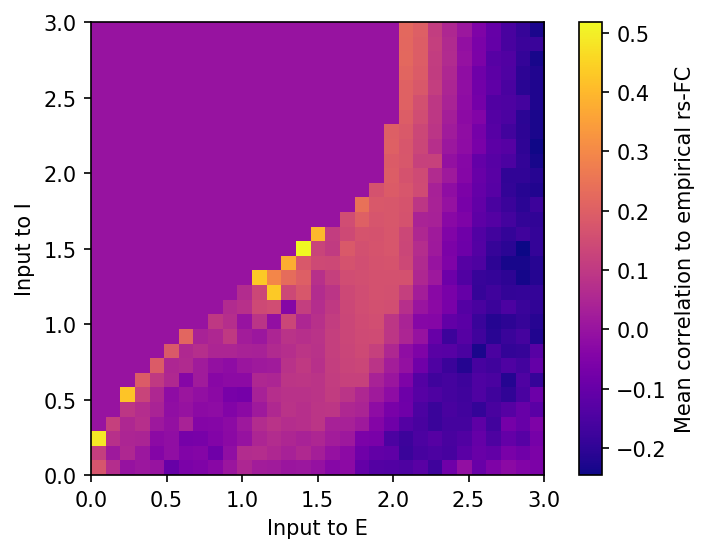

In [85]:
plt.figure(dpi=150)
plt.imshow(search.dfResults.pivot_table(values='bold_cc', index = 'mui_ext_mean', columns='mue_ext_mean'), \
           extent = [min(search.dfResults.mue_ext_mean), max(search.dfResults.mue_ext_mean),
                     min(search.dfResults.mui_ext_mean), max(search.dfResults.mui_ext_mean)], origin='lower')
plt.colorbar(label='Mean correlation to empirical rs-FC')
plt.xlabel("Input to E")
plt.ylabel("Input to I")